For one of our models, we have decided to use k-Nearest Neighbours. While kNN has some limitations, particularly with computational efficiency and sensitivity to irrelevant features, kNN was selected for its interpretability and ease of implementation. Its non-parametric nature means that it makes no assumptions about the underlying distribution of the data, a useful characteristic in situations like ours where the dataset is imbalanced.

# Preparation

In [27]:
import math
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, make_scorer, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from imblearn.over_sampling import SMOTE

In [28]:
# Load the training and testing split from the pickle file
with open('../data/train_splits.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

# Load the different splits
with open('train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

We test on a variety of data splits to enhance the reliability of our model evaluation. It helps ensure that our model is not just fitting the data it has seen but is capable of making accurate predictions on new, unseen data, thus increasing its practical value.

In [29]:
# Define the Balanced MCC Macro Average function
def balanced_MCC_macro_avg(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    classes = C.shape[0]
    bal_MCC_each_class = []
    for i in range(classes):
        TP = C[i][i]
        FN = 0
        FP = 0
        TN = 0
        for j in range(classes):
            if j != i:
                FN += C[i][j]
                FP += C[j][i]
                for k in range(classes):
                    if k != i:
                        TN += C[j][k]
        sens = TP / (TP + FN) if (TP + FN) != 0 else 0
        spec = TN / (TN + FP) if (TN + FP) != 0 else 0
        x = (sens + spec - 1) / (math.sqrt(1 - (sens - spec)**2)) if (1 - (sens - spec)**2) != 0 else 0
        bal_MCC_each_class.append(x)
    return np.mean(bal_MCC_each_class)

Balanced MCC provides an additional robustness check, as it averages balanced metrics across classes.

# Standard Model
First we will train and test our model on the 4 different training splits and compute some metrics with a k (number of neighbors) value of 5.

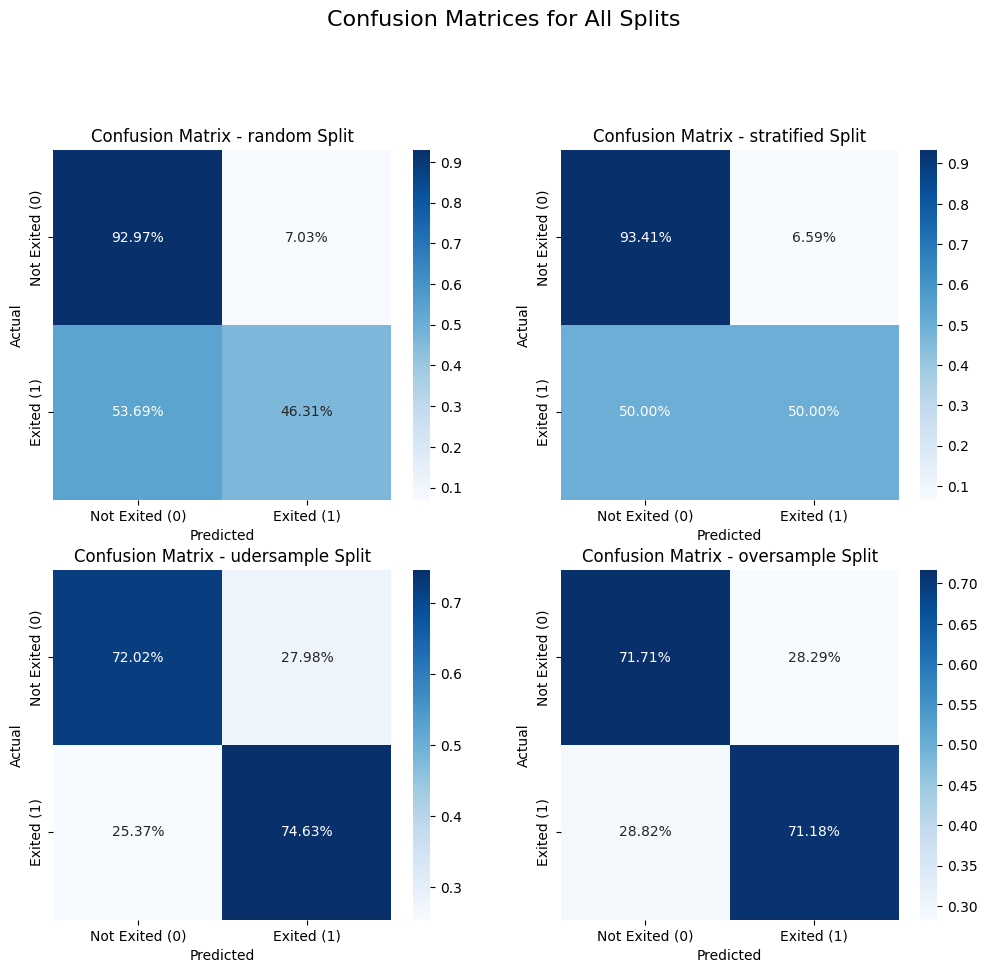

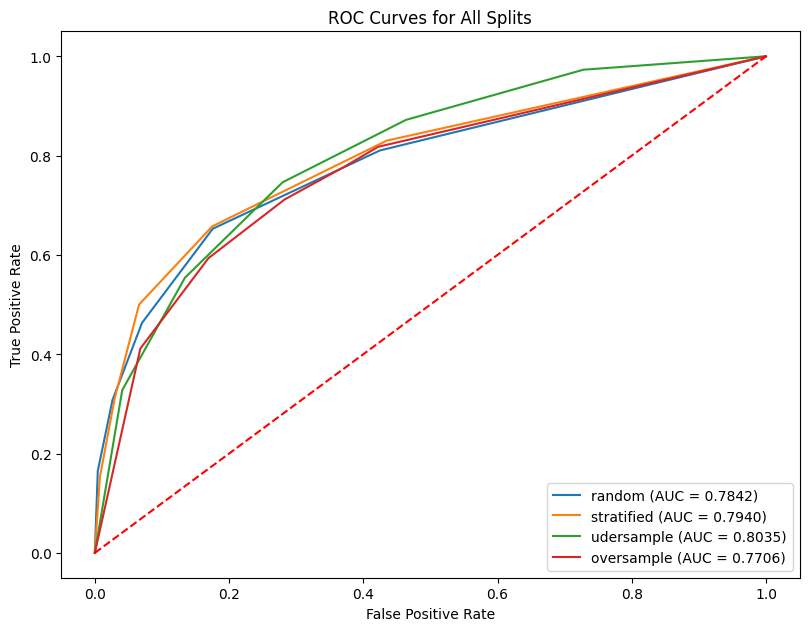

            precision    recall  f1_score   roc_auc  balanced_mcc
random       0.626667  0.551724  0.532578  0.784203      0.444120
stratified   0.659091  0.551724  0.568627  0.793991      0.481909
udersample   0.404539  0.551724  0.524675  0.803465      0.466665
oversample   0.390541  0.551724  0.504363  0.770639      0.428893


In [30]:
# Initialize figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Initialize a new figure for ROC curves
plt.figure(figsize=(8,6))

# Initialize dictionary to store performance metrics for each split
performance_metrics = {}

# Iterate over each split in split_data and process them
for idx, split in enumerate(split_data.keys()):
    # Unpack the current split
    X_train_split, X_val_split, y_train_split, y_val_split = split_data[split]
    
    # Scale the features
    scaler = StandardScaler() #We apply StandardScaler to normalize the features, which is necessary for distance-based models like kNN.
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Train KNN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_scaled, y_train_split)
    
    # Predict on validation set
    y_val_pred = knn_model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    
    # Predict on test set
    y_test_pred = knn_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)
    
    # Get classification report
    test_report = classification_report(y_test_raw, y_test_pred, output_dict=True)
    
    # Plot the confusion matrix for the validation set 
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    tn, fp, fn, tp = conf_matrix.ravel() #Extracts raw counts from the confusion matrix 
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] #Normalize the confusion matrix by the number of true samples per class
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx], #Plot confusion matrix
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Extract performance metrics for class 1
    precision = test_report['1']['precision']
    Recall = test_report['1']['recall']
    F1_score = test_report['1']['f1-score']
    
    # ROC curve
    y_test_pred_prob = knn_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
    
    # Calculate Balanced MCC Macro Average
    balanced_mcc = balanced_MCC_macro_avg(y_test_raw, y_test_pred)
    
    # Store performance metrics
    performance_metrics[split] = {
        'precision': precision,
        'recall': recall,
        'f1_score': F1_score,
        'roc_auc': roc_auc,
        'balanced_mcc': balanced_mcc  # Add Balanced MCC here
    }

# Finalize confusion matrix plot
plt.tight_layout()
fig.suptitle('Confusion Matrices for All Splits', y=1.02, fontsize=16)

# Finalize ROC curves plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Splits')
plt.legend(loc='lower right')
plt.show()

# Output the performance metrics for each split, including Balanced MCC
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(performance_df)

## Analysis

Undersampling leads to the highest recall and AUC, showing that it is effective at identifying churners, but the trade-off is lower precision.

Stratified splitting shows the best balance overall with the highest F1-score and balanced MCC, suggesting that maintaining the original class distribution during splitting improves both precision and recall without introducing excessive noise.

Random splitting works moderately well but performs worse than stratified and undersample techniques due to the imbalance in the dataset.

Oversampling leads to the lowest AUC, precision, and balanced MCC, indicating that it may introduce noise or overfit the minority class, reducing overall performance.

Stratified and undersample methods provide the most promising results, with undersampling being better for recall and stratified being better for balanced overall performance. In our bank churning case, we want to prioritise recall but we also don't want the f1-score or balanced mcc to be too low.

# Parameter Tuning Model

Now we will try and optimise the hyperparameter to create a new model with improved performance over our previous model.

The key differences compared to our previous model are:

* Parameter Grid for kNN: A range of potential values for the number of neighbors k (from 1 to 18) is defined. Grid Search Cross-Validation (GridSearchCV) tests each value of k on five folds of the data, aiming to maximize the F1-score for each split. For each split, we use GridSearchCV to find the best value for k. This ensures the kNN model is optimally tuned to detect churned customers.

* The F1-score (harmonic mean of precision and recall) is chosen as the primary metric for hyperparameter tuning. F1-Score is chosen as it is a popular, standard metric that balances both false positives and false negatives. Although recall is our top priority, we don't have a particularly high value for F1-score (0.5-0.57) at the moment and we don't want it to decrease further than this.

Optimal value of k for random split: 3
Optimal value of k for stratified split: 7
Optimal value of k for udersample split: 17
Optimal value of k for oversample split: 1


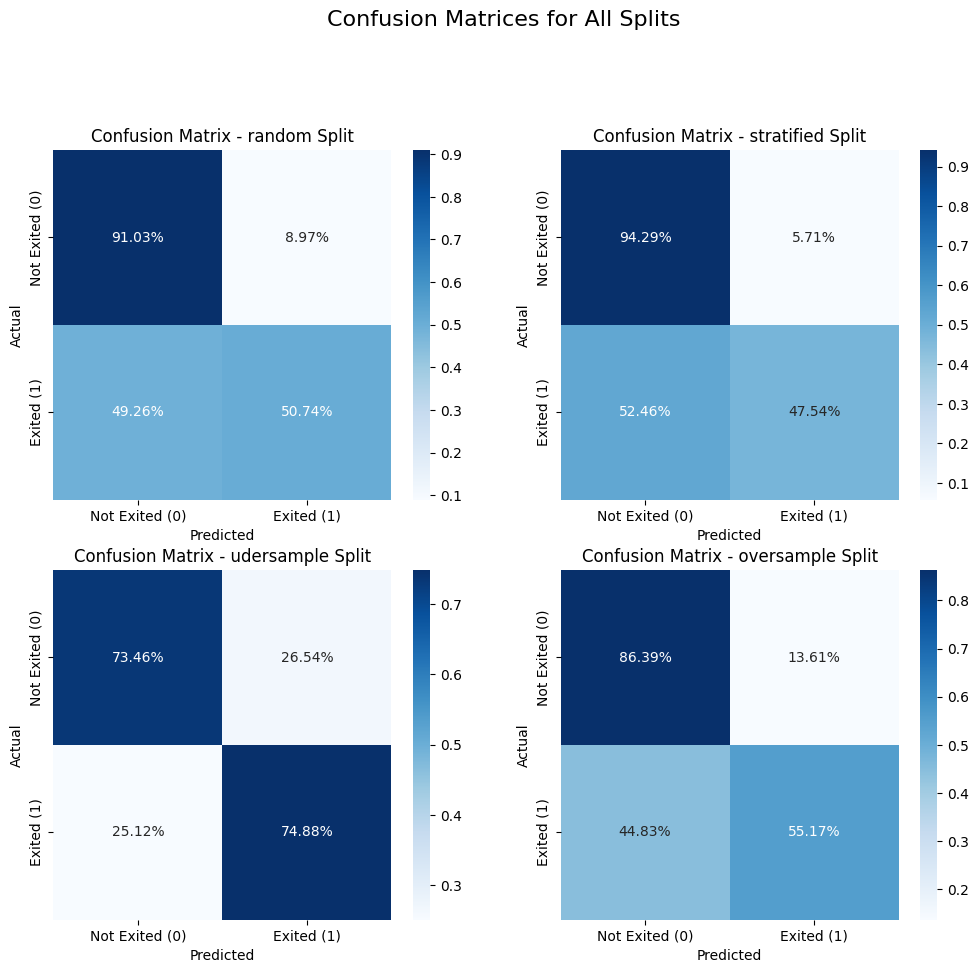

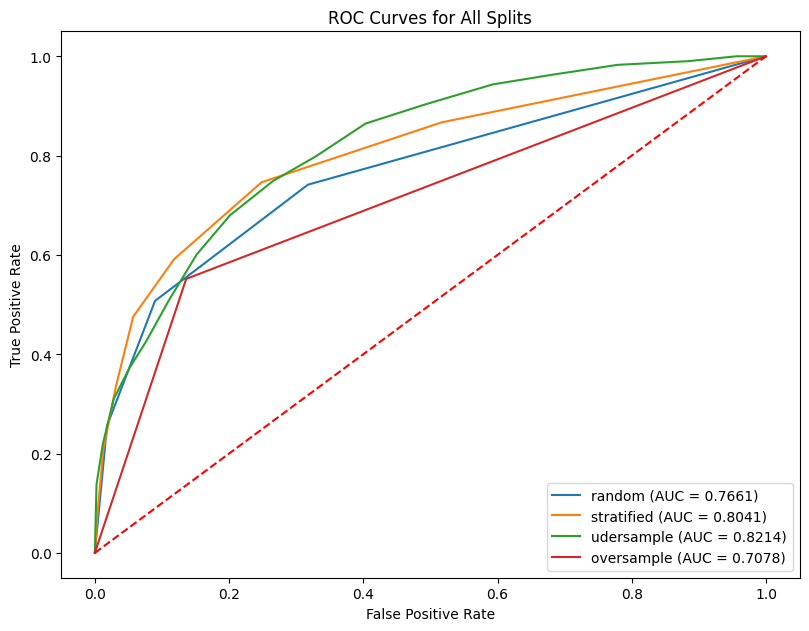

            best_k  precision    recall  f1_score   roc_auc  balanced_mcc
random           3   0.590258  0.507389  0.545695  0.766122      0.456357
stratified       7   0.679577  0.475369  0.559420  0.804144      0.473183
udersample      17   0.418157  0.748768  0.536628  0.821397      0.483447
oversample       1   0.507937  0.551724  0.528926  0.707794      0.437445


In [31]:
# The code below takes a few minutes to run

# Define a scorer for F1-score (or any metric of choice)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Set up a range of k values to search
param_grid = {'n_neighbors': list(range(1, 19))}  # Test k from 1 to 18

# Initialize a new figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Initialize a new figure for ROC curves
plt.figure(figsize=(8, 6))

# Dictionary to store performance metrics for each split
performance_metrics = {}

# Loop over each split
for idx, split in enumerate(split_data.keys()):
    # Unpack the current split
    X_train_split, X_val_split, y_train_split, y_val_split = split_data[split]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Initialize kNN model and GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=f1_scorer, cv=5, n_jobs=-1)
    
    # Fit the model using cross-validation to find the best k
    grid_search.fit(X_train_scaled, y_train_split)
    
    # Get the best k for this split
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Optimal value of k for {split} split: {best_k}")
    
    # Use the best k to train the final model
    knn_best = KNeighborsClassifier(n_neighbors=best_k)
    knn_best.fit(X_train_scaled, y_train_split)
    
    # Predict on validation set
    y_val_pred = knn_best.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    
    # Predict on test set
    y_test_pred = knn_best.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)
    
    # Get classification report
    test_report = classification_report(y_test_raw, y_test_pred, output_dict=True)
    
    #Plot the confusion matrix for the validation set 
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    tn, fp, fn, tp = conf_matrix.ravel() #Extracts raw counts from the confusion matrix 
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] #Normalize the confusion matrix by the number of true samples per class
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx], #Plot confusion matrix
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Extract performance metrics for class 1
    precision = test_report['1']['precision']
    recall = test_report['1']['recall']
    f1_score_val = test_report['1']['f1-score']
    
    # ROC curve
    y_test_pred_prob = knn_best.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
    
    # Calculate Balanced MCC
    balanced_mcc = balanced_MCC_macro_avg(y_test_raw, y_test_pred)
    
    # Store performance metrics for this split
    performance_metrics[split] = {
        'best_k': best_k,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score_val,
        'roc_auc': roc_auc,
        'balanced_mcc': balanced_mcc  # Store the Balanced MCC
    }

# Finalize confusion matrix plot
plt.tight_layout()
fig.suptitle('Confusion Matrices for All Splits', y=1.02, fontsize=16)

# Finalize ROC curves plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Splits')
plt.legend(loc='lower right')
plt.show()

# Output the performance metrics for each split, including Balanced MCC
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(performance_df)

## Analysis

### k-values

The optimal k values used for each split vary significantly. This reflects the varying behavior of the kNN model in response to different splits of the data. Different splits affect the underlying class distribution, which k-NN relies on for calculating distances and neighbors.

Random splits may result in inconsistent neighborhood sizes across classes.

Stratified splits maintain class proportions and lead to more consistent and reliable predictions.

Undersampling reduces the majority class's density, impacting the local neighborhood size and favoring a smaller k.

Oversampling inflates the minority class and may require a larger k to avoid overfitting to repeated data points.

In conclusion, the k-value varies because each splitting method changes the nature of the local neighborhoods in the dataset, and k-NN's performance is highly sensitive to these neighborhood structures.

### Performance Metrics

Optimized k generally improves the balance between precision and recall. For most splits, the optimized k reduces false positives at the cost of recall, but it often improves the F1-score and MCC, leading to better overall classification performance.

In all splits, the optimized k values either maintained or improved the AUC (area under the curve), suggesting that the optimized models are better at distinguishing between classes, even with slight variations in the F1-score and other metrics.

Undersample split has the best AUC and recall, making it excellent for detecting the minority class (churners) but at the cost of more false positives and lower precision.

Stratified split performs the best overall in terms of F1-score, precision, and MCC, making it a well-balanced approach that reduces misclassifications for both churners and non-churners.

Random split has moderate performance across all metrics, but it's outperformed by the stratified and undersample splits, showing that random sampling doesn't handle class imbalance as well.

Oversample split performs the worst across almost all metrics, including AUC, precision, F1-score, and MCC, indicating that oversampling introduces noise and leads to overfitting, causing the model to perform poorly in generalizing predictions.

The stratified split is the best approach here for balanced performance, while the undersample split is ideal for maximizing recall and focusing on identifying churners. Oversample split leads to overfitting and should likely be avoided.

The undersample split is the model best suited for our needs.

## SMOTE

SMOTE is an over-sampling technique used to generate synthetic samples for the minority class. It works by:

* Selecting Samples: For each instance in the minority class, SMOTE selects one or more of its k-nearest neighbors (based on a specified distance metric).
* Creating Synthetic Examples: New samples are created along the line segments between the minority instance and its selected neighbors. This increases the minority class size while adding variability, making the decision boundary more generalized.

The benefits of applying SMOTE to the raw test and train data are:

* Reduces Overfitting: By introducing new, synthetic examples rather than simply duplicating existing ones, SMOTE helps mitigate overfitting.

* Improves Generalization: The model learns from a more balanced dataset, enhancing its ability to generalize to unseen data.

In [32]:
# Apply SMOTE to the raw training data (X_train_raw, y_train_raw)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_raw, y_train_raw)

# Scale the SMOTE-applied training data
X_train_smote_scaled = scaler.fit_transform(X_train_smote)

# Initialize kNN model and GridSearchCV for SMOTE-applied data
knn_smote = KNeighborsClassifier()
grid_search_smote = GridSearchCV(estimator=knn_smote, param_grid=param_grid, scoring=f1_scorer, cv=5, n_jobs=-1)

# Fit the model using cross-validation to find the best k for SMOTE data
grid_search_smote.fit(X_train_smote_scaled, y_train_smote)

# Get the best k for SMOTE-applied data
best_k_smote = grid_search_smote.best_params_['n_neighbors']
print(f"Optimal value of k for SMOTE-applied data: {best_k_smote}")

# Use the best k to train the final model for SMOTE-applied data
knn_smote_best = KNeighborsClassifier(n_neighbors=best_k_smote)
knn_smote_best.fit(X_train_smote_scaled, y_train_smote)

# Predict on test set for SMOTE-applied data
y_test_pred_smote = knn_smote_best.predict(X_test_scaled)

# Get classification report for SMOTE-applied data
test_report_smote = classification_report(y_test_raw, y_test_pred_smote, output_dict=True)

# Extract and calculate performance metrics for SMOTE-applied data
precision_smote = test_report_smote['1']['precision']
recall_smote = test_report_smote['1']['recall']
f1_score_smote = test_report_smote['1']['f1-score']
roc_auc_smote = roc_auc_score(y_test_raw, y_test_pred_smote)
balanced_mcc_smote = balanced_MCC_macro_avg(y_test_raw, y_test_pred_smote)

# Store performance metrics for SMOTE
performance_metrics['SMOTE'] = {
    'best_k': best_k_smote,
    'precision': precision_smote,
    'recall': recall_smote,
    'f1_score': f1_score_smote,
    'roc_auc': roc_auc_smote,
    'balanced_mcc': balanced_mcc_smote  # Store the Balanced MCC
}

# Output the performance metrics for each split and SMOTE
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(performance_df)

Optimal value of k for SMOTE-applied data: 1
            best_k  precision    recall  f1_score   roc_auc  balanced_mcc
random           3   0.590258  0.507389  0.545695  0.766122      0.456357
stratified       7   0.679577  0.475369  0.559420  0.804144      0.473183
udersample      17   0.418157  0.748768  0.536628  0.821397      0.483447
oversample       1   0.507937  0.551724  0.528926  0.707794      0.437445
SMOTE            1   0.457249  0.605911  0.521186  0.711362      0.432451


SMOTE doesn't perform that well for our needs compared to the undersample, as it has a lower score in terms of recall, f1 and balanced mcc.

# Weighted KNN

Weighted k-Nearest Neighbors (Weighted kNN) is a variation of the traditional k-Nearest Neighbors (kNN) algorithm that assigns different weights to neighbors based on their distance from the query point. Unlike standard kNN, where all neighbors contribute equally to the classification decision, weighted kNN emphasizes the influence of closer neighbors more significantly.

Weighted kNN can often yield better performance than standard kNN by:

* Enhancing the influence of relevant, nearby instances.
* Better handling imbalanced datasets by reducing the overwhelming impact of distant majority class neighbors.
* Capturing local data structures more effectively.
* Leading to more accurate and robust predictions, particularly in complex or skewed classification problems.

Optimal value of k for random split: 5, weight: distance
Optimal value of k for stratified split: 7, weight: distance
Optimal value of k for udersample split: 17, weight: distance
Optimal value of k for oversample split: 1, weight: uniform


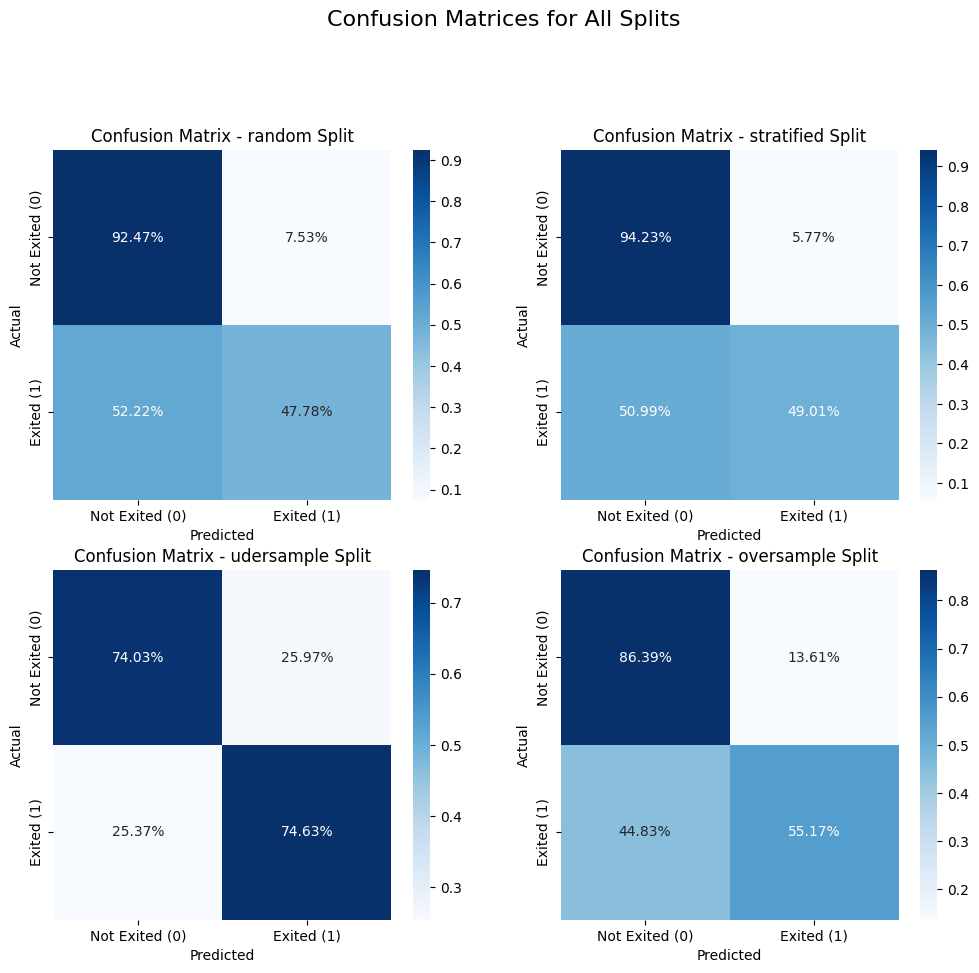

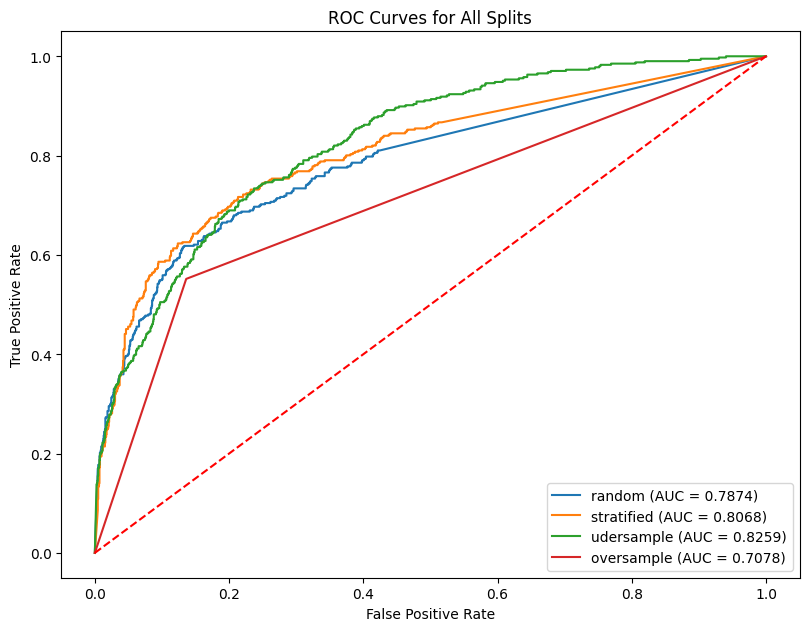

            best_k   weights  precision    recall  f1_score   roc_auc  \
random           5  distance   0.617834  0.477833  0.538889  0.787443   
stratified       7  distance   0.683849  0.490148  0.571019  0.806801   
udersample      17  distance   0.422594  0.746305  0.539626  0.825873   
oversample       1   uniform   0.507937  0.551724  0.528926  0.707794   

            balanced_mcc  
random          0.449982  
stratified      0.484816  
udersample      0.486590  
oversample      0.437445  


In [33]:
# The code below takes a few minutes to run

# Define a scorer for F1-score (or any metric of choice)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Set up a range of k values to search
param_grid = {'n_neighbors': list(range(1, 19)), 'weights': ['uniform', 'distance']}  # Test k from 1 to 18 and both weight options

# Initialize a new figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Initialize a new figure for ROC curves
plt.figure(figsize=(8, 6))

# Dictionary to store performance metrics for each split
performance_metrics = {}

# Loop over each split
for idx, split in enumerate(split_data.keys()):
    # Unpack the current split
    X_train_split, X_val_split, y_train_split, y_val_split = split_data[split]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Initialize kNN model and GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=f1_scorer, cv=5, n_jobs=-1)
    
    # Fit the model using cross-validation to find the best k
    grid_search.fit(X_train_scaled, y_train_split)
    
    # Get the best parameters for this split
    best_params = grid_search.best_params_
    best_k = best_params['n_neighbors']
    best_weight = best_params['weights']
    print(f"Optimal value of k for {split} split: {best_k}, weight: {best_weight}")
    
    # Use the best k and weights to train the final model
    knn_best = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)
    knn_best.fit(X_train_scaled, y_train_split)
    
    # Predict on validation set
    y_val_pred = knn_best.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    
    # Predict on test set
    y_test_pred = knn_best.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)
    
    # Get classification report
    test_report = classification_report(y_test_raw, y_test_pred, output_dict=True)
    
    # Plot the confusion matrix for the validation set 
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    tn, fp, fn, tp = conf_matrix.ravel()  # Extracts raw counts from the confusion matrix 
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix by the number of true samples per class
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],  # Plot confusion matrix
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Extract performance metrics for class 1
    precision = test_report['1']['precision']
    recall = test_report['1']['recall']
    f1_score_val = test_report['1']['f1-score']
    
    # ROC curve
    y_test_pred_prob = knn_best.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
    
    # Calculate Balanced MCC
    balanced_mcc = balanced_MCC_macro_avg(y_test_raw, y_test_pred)

    # Store performance metrics for this split
    performance_metrics[split] = {
        'best_k': best_k,
        'weights': best_weight,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score_val,
        'roc_auc': roc_auc,
        'balanced_mcc': balanced_mcc  # Store the Balanced MCC
    }

# Finalize confusion matrix plot
plt.tight_layout()
fig.suptitle('Confusion Matrices for All Splits', y=1.02, fontsize=16)

# Finalize ROC curves plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Splits')
plt.legend(loc='lower right')
plt.show()

# Output the performance metrics for each split, including Balanced MCC
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(performance_df)


## Analysis

The best weight for most of the splits has been determined as "distance". This means that the algorithm assigns more importance to neighbors that are closer to the query point. Distance weights generally performed better  which suggests that prioritizing closer neighbors helps better capture the underlying structure of your data.

However, in terms of our most appropriate model, undersample, the weighted knn model has not affected the recall and f1-score much.

Overall, from the models we have generated, undersample in both the parameter tuning model and weighted knn model seem to be the best performing model in our scenario.

## Final Remarks

Overall KNN's simplicity is advantageous, it doesn’t require training like many other models, which means it's quick to implement and test. We have shown that for our purposes, kNN could be effective with additional preprocessing like feature scaling and class balancing techniques (SMOTE, undersampling).

However, the variation in optimal k across different splits suggests that the model’s performance may not generalize well to unseen data. The sensitivity to class imbalance and feature scaling is also a challenge, and computational cost can become a concern if the dataset grows.

# References

* https://www.blog.trainindata.com/overcoming-class-imbalance-with-smote/#:~:text=The%20k%20parameter%20in%20SMOTE,time%20and%20computing%20resource%20consuming.
* https://visualstudiomagazine.com/articles/2019/04/01/weighted-k-nn-classification.aspx